<h1>IMPORTING DATASET</h1>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content

Mounted at /content/gdrive
/content


In [ ]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json
token = {"username":"darkangel24","key":"141b363f52c1ebe770b120c3047cec0e"}
import json
with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d rmisra/news-category-dataset
!unzip news-category-dataset.zip

 67% 17.0M/25.4M [00:00<00:00, 9.58MB/s]
100% 25.4M/25.4M [00:01<00:00, 26.3MB/s]
Archive:  news-category-dataset.zip
  inflating: News_Category_Dataset_v2.json  


In [ ]:
!rm -r /content/sample_data
!rm /content/news-category-dataset.zip

In [ ]:
!pip install emoji
!pip install pyenchant
!apt install enchant

     |████████████████████████████████| 170 kB 3.9 MB/s 
  Created wheel for emoji: filename=emoji-1.6.1-py3-none-any.whl size=169314 sha256=a6a2ed150b4a8613a194e89bf60875102e43e3adcc473a719225843cb2311911
  Stored in directory: /root/.cache/pip/wheels/ea/5f/d3/03d313ddb3c2a1a427bb4690f1621eea60fe6f2a30cc95940f
Successfully built emoji
     |████████████████████████████████| 55 kB 2.3 MB/s 
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  aspell aspell-en dictionaries-common emacsen-common hunspell-en-us
  libaspell15 libenchant1c2a libhunspell-1.6-0 libtext-iconv-perl
Suggested packages:
  aspell-doc spellutils wordlist hunspell openoffice.org-hunspell
  | openoffice.org-core libenchant-voikko
The following NEW packages will be installed:
  aspell aspell-en dictionaries-common emacsen-common enchant hunspell-en-us
  libaspell15 libenchant1c2a libhunspell-1.6-0 libtext-iconv-perl
0 upg

<h1>IMPORTING LIBRARIES AND MODULES</h1>

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import pickle as pkl
import tensorflow.keras as ks
import matplotlib.pyplot as plt
import re
import math
import random as rn
import emoji
import pickle as pkl
import enchant
from tqdm.notebook import tqdm
import nltk
from sklearn.model_selection import train_test_split
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

<h1>READING JSON FILE AND CONVERTING TO CSV</h1>

In [ ]:
dataset = pd.read_json('/content/News_Category_Dataset_v2.json', lines=True)
dataset.to_csv()
df = pd.DataFrame(dataset)
df = df.sample(frac=1)
df.reset_index(drop=True, inplace=True)
df.head()

,category,headline,authors,link,short_description,date
0,ENTERTAINMENT,Your TV Boyfriend Penn Badgley Married A 'Girl...,Cole Delbyck,https://www.huffingtonpost.com/entry/penn-badg...,One less lonely boy.,2017-02-27
1,POLITICS,"As Ramadan Draws To An End, Mosques Worry Abou...",Carol Kuruvilla,https://www.huffingtonpost.com/entry/ramadan-m...,Rising hate crimes mean cameras and armed guar...,2017-06-23
2,POLITICS,Here’s How Donald Trump’s Authoritarianism Wou...,,https://www.huffingtonpost.comhttp://nymag.com...,"At various points in his career, Donald Trump ...",2016-05-13
3,CRIME,Family Of Four Found Dead In Michigan Home,,https://www.huffingtonpost.com/entry/family-of...,"""We'll be on the alert, that's for sure, until...",2015-08-14
4,WELLNESS,GPS Guide: Judith Rich's Galaxy Guide,,https://www.huffingtonpost.com/entry/gps-guide...,The stress and strains of our always-connected...,2012-08-25


<h1>CHECKING FOR MISSING VALUES</h1>

In [ ]:
df.isna().sum()

category             0
headline             0
authors              0
link                 0
short_description    0
date                 0
dtype: int64

<h1>DROPPING IRRELEVANT COLUMNS</h1>

In [ ]:
df = df.drop(columns=['date', 'authors', 'link'])
df.head()

,category,headline,short_description
0,ENTERTAINMENT,Your TV Boyfriend Penn Badgley Married A 'Girl...,One less lonely boy.
1,POLITICS,"As Ramadan Draws To An End, Mosques Worry Abou...",Rising hate crimes mean cameras and armed guar...
2,POLITICS,Here’s How Donald Trump’s Authoritarianism Wou...,"At various points in his career, Donald Trump ..."
3,CRIME,Family Of Four Found Dead In Michigan Home,"""We'll be on the alert, that's for sure, until..."
4,WELLNESS,GPS Guide: Judith Rich's Galaxy Guide,The stress and strains of our always-connected...


<h1>COMBINE CATEGORIES</h1>

In [ ]:
df['category'] = df['category'].replace({'ARTS': 'ARTS & CULTURE',
                                         'CULTURE & ARTS': 'ARTS & CULTURE',
                                         'PARENTS': 'PARENTING',
                                         'STYLE': 'STYLE & BEAUTY',
                                         'WORLDPOST': 'WORLD',
                                         'THE WORLDPOST': 'WORLD',
                                         'WORLD NEWS': 'WORLD',
                                         'TASTE': 'FOOD & DRINK',
                                         'GREEN': 'ENVIRONMENT'})

<h1>LOWER TEXT</h1>

In [ ]:
def lower(sentence):
    return sentence.lower()
df['headline'] = df['headline'].apply(lambda x: lower(x))
df['short_description'] = df['short_description'].apply(lambda x: lower(x))
df.head()

,category,headline,short_description
0,ENTERTAINMENT,your tv boyfriend penn badgley married a 'girl...,one less lonely boy.
1,POLITICS,"as ramadan draws to an end, mosques worry abou...",rising hate crimes mean cameras and armed guar...
2,POLITICS,here’s how donald trump’s authoritarianism wou...,"at various points in his career, donald trump ..."
3,CRIME,family of four found dead in michigan home,"""we'll be on the alert, that's for sure, until..."
4,WELLNESS,gps guide: judith rich's galaxy guide,the stress and strains of our always-connected...


<h1>REPLACING EMOJIS</h1>

In [ ]:
def remove_emojis(sentence):
    return emoji.demojize(sentence, delimiters=("", ""))
df['headline'] = df['headline'].apply(lambda x: remove_emojis(x))
df['short_description'] = df['short_description'].apply(lambda x: remove_emojis(x))
df.head()

,category,headline,short_description
0,ENTERTAINMENT,your tv boyfriend penn badgley married a 'girl...,one less lonely boy.
1,POLITICS,"as ramadan draws to an end, mosques worry abou...",rising hate crimes mean cameras and armed guar...
2,POLITICS,here’s how donald trump’s authoritarianism wou...,"at various points in his career, donald trump ..."
3,CRIME,family of four found dead in michigan home,"""we'll be on the alert, that's for sure, until..."
4,WELLNESS,gps guide: judith rich's galaxy guide,the stress and strains of our always-connected...


<h1>TOKENIZING THE SENTENCE</h1>

In [ ]:
def tokenize(sentence):
    sentence_list = sentence.split(' ')
    for i in sentence_list:
        if i == '':
            sentence_list.remove(i)
    return sentence_list
df['headline'] = df['headline'].apply(lambda x: tokenize(x))
df['short_description'] = df['short_description'].apply(lambda x: tokenize(x))
df.head()

,category,headline,short_description
0,ENTERTAINMENT,"[your, tv, boyfriend, penn, badgley, married, ...","[one, less, lonely, boy.]"
1,POLITICS,"[as, ramadan, draws, to, an, end,, mosques, wo...","[rising, hate, crimes, mean, cameras, and, arm..."
2,POLITICS,"[here’s, how, donald, trump’s, authoritarianis...","[at, various, points, in, his, career,, donald..."
3,CRIME,"[family, of, four, found, dead, in, michigan, ...","[""we'll, be, on, the, alert,, that's, for, sur..."
4,WELLNESS,"[gps, guide:, judith, rich's, galaxy, guide]","[the, stress, and, strains, of, our, always-co..."


<h1>SEPERATE COMPOUND WORDS</h1>


In [ ]:
contractions = {"ain't": "are not", "aren't": "are not", "can't": "cannot", "can't've": "cannot have", "'cause": "because",
                "could've": "could have", "couldn't": "could not", "couldn't've": "could not have", "didn't": "did not",
                "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hadn't've": "had not have", "hasn't": "has not",
                "haven't": "have not", "he'd": "he would", "he'd've": "he would have", "he'll": "he will", "he'll've": "he will have",
                "he's": "he is", "here's": "here is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "ow is", "i'd": "I would",
                "i'd've": "I would have", "i'll": "I will", "i'll've": "I will have", "i'm": "I am", "i've": "I have",
                "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have",
                "it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have", "mightn't": "might not",
                "mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have",
                "needn't": "need not", "needn't've": "need not have", "o'clock": "of the clock", "oughtn't": "ought not",
                "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have",
                "so's": "so is", "that'd": "that would", "that'd've": "that would have", "that's": "that is", "'em": "them",
                "there'd": "there would", "there'd've": "there would have", "there's": "there is", "they'd": "they would",
                "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are",
                "they've": "they have", "to've": "to have", 'u.s.': 'united states', 'u.s.a.': 'united states of america', "wasn't": "was not", "we'd": "we would", "we'd've": "we would have",
                "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not",
                "what'll": "what will", "what'll've": "what will have", "what're": "what are", "what's": "what is",
                "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                "y'all'd": "you all would", "y'all'd've": "you all would have", "y'all're": "you all are", "y'all've": "you all have",
                "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                "you're": "you are", "you've": "you have", 'yrs': 'years', 'yrsold': 'years old', '&': ' and '}
def seperate_compound_words(sentence_list):
    for i, _ in enumerate(sentence_list):
        for j in contractions:
            if sentence_list[i] == j:
                sentence_list[i] = contractions[j]
    sentence = ''
    for i in sentence_list:
        sentence = sentence + ' ' + i
    return sentence
df['headline'] = df['headline'].apply(lambda x: seperate_compound_words(x))
df['short_description'] = df['short_description'].apply(lambda x: seperate_compound_words(x))
df.head()

,category,headline,short_description
0,ENTERTAINMENT,your tv boyfriend penn badgley married a 'gir...,one less lonely boy.
1,POLITICS,"as ramadan draws to an end, mosques worry abo...",rising hate crimes mean cameras and armed gua...
2,POLITICS,here’s how donald trump’s authoritarianism wo...,"at various points in his career, donald trump..."
3,CRIME,family of four found dead in michigan home,"""we'll be on the alert, that is for sure, unt..."
4,WELLNESS,gps guide: judith rich's galaxy guide,the stress and strains of our always-connecte...


<h1>REMOVE PUNCTUATIONS</h1>

In [ ]:
def remove_punctuations(sentence):
    new_sentence = re.sub(r'[^\w\s]', ' ', sentence, re.UNICODE)
    return new_sentence
df['headline'] = df['headline'].apply(lambda x: remove_punctuations(x))
df['short_description'] = df['short_description'].apply(lambda x: remove_punctuations(x))
df.head()

,category,headline,short_description
0,ENTERTAINMENT,your tv boyfriend penn badgley married a gir...,one less lonely boy
1,POLITICS,as ramadan draws to an end mosques worry abo...,rising hate crimes mean cameras and armed gua...
2,POLITICS,here s how donald trump s authoritarianism wo...,at various points in his career donald trump...
3,CRIME,family of four found dead in michigan home,we ll be on the alert that is for sure unt...
4,WELLNESS,gps guide judith rich s galaxy guide,the stress and strains of our always connecte...


In [ ]:
df['headline'] = df['headline'].apply(lambda x: tokenize(x))
df['short_description'] = df['short_description'].apply(lambda x: tokenize(x))
df.head()

,category,headline,short_description
0,ENTERTAINMENT,"[your, tv, boyfriend, penn, badgley, married, ...","[one, less, lonely, boy]"
1,POLITICS,"[as, ramadan, draws, to, an, end, mosques, wor...","[rising, hate, crimes, mean, cameras, and, arm..."
2,POLITICS,"[here, s, how, donald, trump, s, authoritarian...","[at, various, points, in, his, career, donald,..."
3,CRIME,"[family, of, four, found, dead, in, michigan, ...","[we, ll, be, on, the, alert, that, is, for, su..."
4,WELLNESS,"[gps, guide, judith, rich, s, galaxy, guide]","[the, stress, and, strains, of, our, always, c..."


<h1>LEMMATIZING WORDS</h1>

In [ ]:
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()
def lemmatize(sentence_list):
    new_list = []
    for i in sentence_list:
        new_list.append(lemmatizer.lemmatize(i))
    return new_list
df['headline'] = df['headline'].apply(lambda x: lemmatize(x))
df['short_description'] = df['short_description'].apply(lambda x: lemmatize(x))
df.head()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


,category,headline,short_description
0,ENTERTAINMENT,"[your, tv, boyfriend, penn, badgley, married, ...","[one, le, lonely, boy]"
1,POLITICS,"[a, ramadan, draw, to, an, end, mosque, worry,...","[rising, hate, crime, mean, camera, and, armed..."
2,POLITICS,"[here, s, how, donald, trump, s, authoritarian...","[at, various, point, in, his, career, donald, ..."
3,CRIME,"[family, of, four, found, dead, in, michigan, ...","[we, ll, be, on, the, alert, that, is, for, su..."
4,WELLNESS,"[gps, guide, judith, rich, s, galaxy, guide]","[the, stress, and, strain, of, our, always, co..."


<h1>REMOVING NONSENSICAL WORDS</h1>

In [ ]:
eng_dict = enchant.Dict("en_US")
def remove_incorrect_words(sentence_list):
    for i in sentence_list:
        if i == '' or not eng_dict.check(i):
            sentence_list.remove(i)
    return sentence_list
df['headline'] = df['headline'].apply(lambda x: remove_incorrect_words(x))
df['short_description'] = df['short_description'].apply(lambda x: remove_incorrect_words(x))
df.head()

,category,headline,short_description
0,ENTERTAINMENT,"[your, boyfriend, badgley, married, a, girl, s...","[one, lonely, boy]"
1,POLITICS,"[a, draw, to, an, end, mosque, worry, about, s...","[rising, hate, crime, mean, camera, and, armed..."
2,POLITICS,"[here, s, how, trump, s, authoritarianism, wou...","[at, various, point, in, his, career, trump, h..."
3,CRIME,"[family, of, four, found, dead, in, home]","[we, ll, be, on, the, alert, that, is, for, su..."
4,WELLNESS,"[guide, rich, s, galaxy, guide]","[the, stress, and, strain, of, our, always, co..."


In [ ]:
def list_to_sentence(sentence_list):
    sentence = ''
    for i in sentence_list:
        sentence = sentence + ' ' + i
    return sentence
df['headline'] = df['headline'].apply(lambda x: list_to_sentence(x))
df['short_description'] = df['short_description'].apply(lambda x: list_to_sentence(x))
df.head()

,category,headline,short_description
0,ENTERTAINMENT,your boyfriend badgley married a girl star s ...,one lonely boy
1,POLITICS,a draw to an end mosque worry about security,rising hate crime mean camera and armed guard...
2,POLITICS,here s how trump s authoritarianism would act...,at various point in his career trump ha prais...
3,CRIME,family of four found dead in home,we ll be on the alert that is for sure until ...
4,WELLNESS,guide rich s galaxy guide,the stress and strain of our always connected...


<h1>TARGET ENCODING</h1>

In [ ]:
sorted(df['category'].unique())

['ARTS & CULTURE',
 'BLACK VOICES',
 'BUSINESS',
 'COLLEGE',
 'COMEDY',
 'CRIME',
 'DIVORCE',
 'EDUCATION',
 'ENTERTAINMENT',
 'ENVIRONMENT',
 'FIFTY',
 'FOOD & DRINK',
 'GOOD NEWS',
 'HEALTHY LIVING',
 'HOME & LIVING',
 'IMPACT',
 'LATINO VOICES',
 'MEDIA',
 'MONEY',
 'PARENTING',
 'POLITICS',
 'QUEER VOICES',
 'RELIGION',
 'SCIENCE',
 'SPORTS',
 'STYLE & BEAUTY',
 'TECH',
 'TRAVEL',
 'WEDDINGS',
 'WEIRD NEWS',
 'WELLNESS',
 'WOMEN',
 'WORLD']

In [ ]:
def plot_bar_graph_of_unique_quantities(dataframe, col):
    data = dict(dataframe[col].value_counts())
    courses = list(data.keys())
    values = list(data.values())
    fig = plt.figure(figsize = (20, 10))
    plt.bar(courses, values, color ='green', width = 0.4)
    plt.ylabel("COUNT")
    plt.xlabel("CATEGORY")
    plt.title(f"COUNT VS CATEGORY")
    plt.show()
plot_bar_graph_of_unique_quantities(dataframe, 'category')

In [ ]:
Y = df['category']
Y = pd.get_dummies(Y)
Y.shape

(200853, 33)

<h1>FEATURE ENCODING</h1>

In [ ]:
df['input'] = df['headline'].astype(str) + ' ' + df['short_description'].astype(str)
df.head()

,category,headline,short_description,input
0,ENTERTAINMENT,your boyfriend badgley married a girl star s ...,one lonely boy,your boyfriend badgley married a girl star s ...
1,POLITICS,a draw to an end mosque worry about security,rising hate crime mean camera and armed guard...,a draw to an end mosque worry about security ...
2,POLITICS,here s how trump s authoritarianism would act...,at various point in his career trump ha prais...,here s how trump s authoritarianism would act...
3,CRIME,family of four found dead in home,we ll be on the alert that is for sure until ...,family of four found dead in home we ll be o...
4,WELLNESS,guide rich s galaxy guide,the stress and strain of our always connected...,guide rich s galaxy guide the stress and str...


In [ ]:
max_words = 53280
max_sequence_length = 250
embedding_dims = 100

In [ ]:
tokenizer = ks.preprocessing.text.Tokenizer(num_words=max_words, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['input'].values)
word_index = tokenizer.word_index
unique_words = len(word_index)
unique_words

51442

In [ ]:
with open('tokenizer.pickle', 'wb') as handle:
    pkl.dump(tokenizer, handle, protocol=pkl.HIGHEST_PROTOCOL)

In [ ]:
X = tokenizer.texts_to_sequences(df['input'].values)
X = ks.preprocessing.sequence.pad_sequences(X, maxlen=max_sequence_length)
X.shape

(200853, 250)

<h1>SPLITTING DATAFRAME TO TRAIN AND TEST DATA<h1>

In [ ]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=24)
X_test, X_val, Y_test, Y_val = train_test_split(X_val, Y_val, test_size=0.5, random_state=24)
X_train.shape, Y_train.shape, X_val.shape, Y_val.shape, X_test.shape, Y_test.shape

((160682, 250),
 (160682, 33),
 (20086, 250),
 (20086, 33),
 (20085, 250),
 (20085, 33))

<h1>CREATE MODEL ARCHITECTURE</h1>

In [ ]:
model = ks.models.Sequential()

model.add(ks.layers.Embedding(max_words, embedding_dims, input_length=X_train.shape[1]))
model.add(ks.layers.SpatialDropout1D(0.3))

model.add(ks.layers.LSTM(512, dropout=0.2))

model.add(ks.layers.Dense(2048))
model.add(ks.layers.LeakyReLU(alpha=0.2))
model.add(ks.layers.Dropout(0.3))

model.add(ks.layers.Dense(1024))
model.add(ks.layers.LeakyReLU(alpha=0.3))
model.add(ks.layers.Dropout(0.2))

model.add(ks.layers.Dense(512))
model.add(ks.layers.LeakyReLU(alpha=0.1))
model.add(ks.layers.Dropout(0.1))

model.add(ks.layers.Dense(256))
model.add(ks.layers.LeakyReLU(alpha=0.2))

model.add(ks.layers.Dense(128))
model.add(ks.layers.LeakyReLU(alpha=0.3))

model.add(ks.layers.Dense(64))
model.add(ks.layers.LeakyReLU(alpha=0.1))

model.add(ks.layers.Dense(Y.shape[1], activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 250, 100)          5328000   
                                                                 
 spatial_dropout1d (SpatialD  (None, 250, 100)         0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 512)               1255424   
                                                                 
 dense (Dense)               (None, 2048)              1050624   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 2048)              0         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                        

<h1>MODEL COMPILING AND FITTING</h1>

In [ ]:
model.compile(loss=ks.losses.CategoricalCrossentropy(),
              optimizer=ks.optimizers.RMSprop(learning_rate=1e-3),
              metrics = [ks.metrics.CategoricalAccuracy(), ks.metrics.TopKCategoricalAccuracy(k=3)])
e = 100
es = ks.callbacks.EarlyStopping(monitor='val_loss', mode='min', restore_best_weights=False, patience=8)
mc = ks.callbacks.ModelCheckpoint('weights.h5', monitor='val_loss', mode='min', save_best_only=True)
rlrop = ks.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', factor=0.2, patience=4)
fit = model.fit(X_train, Y_train, epochs=e, callbacks=[es, mc, rlrop], validation_data=(X_val, Y_val))

Epoch 1/100
5022/5022 [==============================] - 610s 120ms/step - loss: 2.4123 - categorical_accuracy: 0.3638 - top_k_categorical_accuracy: 0.5590 - val_loss: 1.9482 - val_categorical_accuracy: 0.4881 - val_top_k_categorical_accuracy: 0.6781 - lr: 0.0010
Epoch 2/100
5022/5022 [==============================] - 603s 120ms/step - loss: 1.8827 - categorical_accuracy: 0.5131 - top_k_categorical_accuracy: 0.6984 - val_loss: 1.8167 - val_categorical_accuracy: 0.5330 - val_top_k_categorical_accuracy: 0.7070 - lr: 0.0010
Epoch 3/100
5022/5022 [==============================] - 601s 120ms/step - loss: 1.7036 - categorical_accuracy: 0.5615 - top_k_categorical_accuracy: 0.7434 - val_loss: 1.6939 - val_categorical_accuracy: 0.5761 - val_top_k_categorical_accuracy: 0.7480 - lr: 0.0010
Epoch 4/100
5022/5022 [==============================] - 602s 120ms/step - loss: 1.5926 - categorical_accuracy: 0.5921 - top_k_categorical_accuracy: 0.7703 - val_loss: 1.5771 - val_categorical_accuracy: 0.603

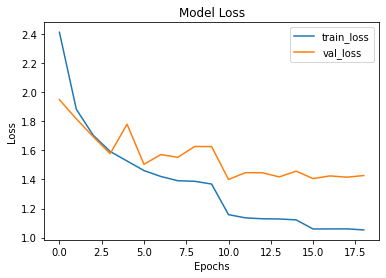

In [ ]:
plt.plot(fit.history['loss'])
plt.plot(fit.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train_loss', 'val_loss'], loc='upper right')
plt.show()

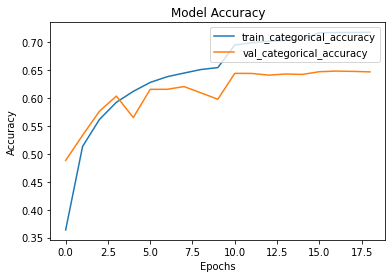

In [ ]:
plt.plot(fit.history['categorical_accuracy'])
plt.plot(fit.history['val_categorical_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train_categorical_accuracy', 'val_categorical_accuracy'], loc='upper right')
plt.show()

In [ ]:
model.save('model.hdf5')
model.evaluate(X_test, Y_test)

628/628 [==============================] - 27s 43ms/step - loss: 1.4103 - categorical_accuracy: 0.6479 - top_k_categorical_accuracy: 0.8250


[1.4102880954742432, 0.6478964686393738, 0.8249937891960144]

In [ ]:
from google.colab import files
files.download('/content/tokenizer.pickle')
files.download('/content/model.hdf5')
files.download('/content/weights.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>